In [166]:
import pandas as pd
import numpy as np
from utils.demandPredictor import *
from utils.PVPredictor import *

class Home():
    # constant attribute
    GRID_LIMIT = 0.5
    BATTERY_CONST = 12.
    UNIT_PRICE = [0.5,0.5,0.5,0.5,0.5,0.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5]
    SELL_PRICE = 0.3
    CHARGE_RATE = 0.1
    
    def __init__(self, battery_const=12., charge_rate=0.1):
        self.battery = 0.
        Home.BATTERY_CONST = battery_const
        Home.CHARGE_RATE = charge_rate
        self.result = None
        self.dic = {'low':[0., 0], 'mid':[0., 0], 'high':[0., 0]}
        self.dp_model = demandPredictor()
        self.dp_model.train(test_size=0.3)
        self.pv_model = PVPredictor()
        self.pv_model.train()
        self.weather_forcast = pd.read_csv('../Data/weather/test_weather.csv')
    
    def set_battery(self, battery_const=12.):
        Home.BATTERY_CONST = battery_const
    
    def grid_limit_check(self, amount, use=True):
        # return 'PV to grid', 'reduce PV'
        if use:
            if amount > Home.GRID_LIMIT:
                #print(amount, Home.GRID_LIMIT)
                return Home.GRID_LIMIT, amount-Home.GRID_LIMIT
            return amount, 0
        return amount, 0
    
    def battery_is_empty(self):
        return (self.battery == 0.)
    
    def battery_is_full(self):
        return (self.battery >= Home.BATTERY_CONST)
    
    def pricing(self, hour, amount):
        if 0 <= hour < 6:
            self.dic['low'][0] += (amount/4.)
        elif 6 <= hour < 16:
            self.dic['mid'][0] += (amount/4.)
        else:
            self.dic['high'][0] += (amount/4.)
            
        if amount < 0:
            # sell to grid
            return amount * Home.SELL_PRICE / 4.
        else:
            # buy from grid
            return amount * Home.UNIT_PRICE[hour] / 4.
        
    def battery_auto_charge(self, charge_from_grid, df, t, autocharge=False, toprint=False):
        if autocharge and charge_from_grid > 0:
            if not self.battery_is_full():  
                # do not charge on high utility price period
                if not 16 <= int(df.at[t, 'DateTime'].split(' ')[1].split(':')[0]) <= 23:
           
                    # still need more electricity from grid
                    if charge_from_grid > Home.BATTERY_CONST - self.battery:
                        if Home.BATTERY_CONST - self.battery >= Home.CHARGE_RATE:
                            charged = Home.CHARGE_RATE
                        else:
                            charged = (Home.BATTERY_CONST - self.battery)
                    else:
                        charged = (Home.BATTERY_CONST - self.battery)

                    df.at[t, 'from_grid'] += charged
                    self.battery += charged
                    charge_from_grid -= charged
            #print(charge_from_grid)
        return charge_from_grid

    def simuate(self, data, autocharge=True, toprint=False, scale=1.):
        data['from_grid'] = ""
        data['sell_to_grid'] = ""
        data['battery_stat'] = ""
        data['cost'] = ""
        data['revenue'] = ""
        data['reduce'] = ""
        demand_used = 0
        pv_used = 0
        charge_from_grid = 0
        date = 0
        
        for t, row in data.iterrows():
            _, month, d = list(map(lambda x: int(x), row['DateTime'].split(' ')[0].split('-')))
            
            if date != d:
                date = d
                # predic demand for today
                demand_used = 0
                demand_pred = self.dp_model.predict([month, date])
                # predict pv for today
                weather = self.weather_forcast.loc[date-1, ['MaxTemperature', 'AvgTemperature', 'MinTemperature', 'MaxHumidity', 'AvgHumidity', 'MinHumidity', 'MaxWindspeed', 'AvgWindspeed', 'MinWindspeed', 'Precipitation']]       
                pv_pred = self.pv_model.predict([weather])[0, 0]
                charge_from_grid = demand_pred - pv_pred
                #print("Predict demand to charge from grid:", charge_from_grid)
            
                if toprint:
                    print("Predict Demand on {:d}/{:d}: {:.2f}".format(month, d, demand_pre[0]))
                    
            # check demand and PV
            deficit = (row['demand'] - row['solar'])/4.
            if deficit > 0:
                # grid or battery involved
                if self.battery_is_empty():
                    # grid involved
                    data.at[t, 'from_grid'] = deficit
                elif deficit > self.battery:
                    # both grid and battery involved
                    data.at[t, 'from_grid'] = deficit - self.battery
                    self.battery = 0 # from battery
                else:
                    # battery involved
                    self.battery -= deficit
                    data.at[t, 'from_grid'] = 0
                data.at[t, 'sell_to_grid'] = 0
                data.at[t, 'reduce'] = 0
            else:
                # charge by PV
                if self.battery_is_full():
                    # sell pv electricity to grid
                    extra = (-1)*deficit
                    extra, reduce = self.grid_limit_check((-1)*deficit)
                    data.at[t, 'sell_to_grid'] = extra
                    data.at[t, 'reduce'] = reduce
                elif self.battery + ((-1)*deficit) > Home.BATTERY_CONST:
                    # charge part of PV and sell part of PV
                    extra = self.battery + ((-1)*deficit) - Home.BATTERY_CONST
                    extra, reduce = self.grid_limit_check(extra)
                    self.battery = Home.BATTERY_CONST
                    data.at[t, 'sell_to_grid'] = extra
                    data.at[t, 'reduce'] = reduce
                else:
                    # charge
                    self.battery += ((-1)*deficit)
                    data.at[t, 'sell_to_grid'] = 0
                    data.at[t, 'reduce'] = 0
                data.at[t, 'from_grid'] = 0
            data.at[t, 'battery_stat'] = self.battery
            demand_used += row['demand']
            charge_from_grid = self.battery_auto_charge(charge_from_grid, data, t, autocharge, True)
        
        self.result = data
        self.cost_calculate()
        self.revenue_calculate()
        
    def cost_calculate(self):
        for index, row in self.result.iterrows():
            self.result.at[index, 'cost'] = self.pricing(int(row['DateTime'].split(' ')[1].split(':')[0]), row['from_grid'])
        
    def revenue_calculate(self):
        for index, row in self.result.iterrows():
            self.result.at[index, 'revenue'] = self.pricing(int(row['DateTime'].split(' ')[1].split(':')[0]), row['sell_to_grid'])    
     
    def total_bill(self):
        date = ''
        total = 0.
        totals = []
        for index, row in self.result.iterrows():
            if date != row['DateTime'].split(' ')[0]:
                totals.append(total)
                total = 0
                date = row['DateTime'].split(' ')[0]
            total += (row['cost']-row['revenue'])
        totals.append(total)
        totals = totals[1:]
        return totals
    
    def show_usage(self):
        total = self.dic['low'][0] + self.dic['mid'][0] + self.dic['high'][0]
        print('total consumption(kw): {:.2f}, low: {:.2f}%, mid: {:.2f}%, high: {:.2f}%'.format(total, 100*self.dic['low'][0]/total, 100*self.dic['mid'][0]/total, 100*self.dic['high'][0]/total))
    
    def show_result(self, start=0, end=0):
        if start == end:
            print(self.result[:])
        else:
            print(self.result[start:end])

In [167]:
demand_test = pd.read_csv('../Data/electricity/test_electricity.csv')

demands = []
for i, row in demand_test.iterrows():
    if row['grid'] < 0:
        demands.append(row['solar'] - ((-1)*row['grid']))
    else:
        demands.append(row['grid']+row['solar'])
demand_test['demand'] = demands

test1, test2, test3 = demand_test.loc[:], demand_test.loc[:], demand_test.loc[:]

print("### Home with battery ###")
home_with_battery = Home()
home_with_battery.simuate(test1, autocharge=False)
print()
print("### Home without battery ###")
home_no_battery = Home(battery_const=0)
home_no_battery.simuate(test2, autocharge=False)
print()
print("### Home with battery & autocharge ###")
home_with_battery_charge = Home()
home_with_battery_charge.simuate(test3, autocharge=True)

### Home with battery ###
Finish preprocessing
weather record size:  (365, 10)
solar record size:  (365, 1)
Train X size:  (292, 10)
Train y size:  (292, 1)
Test X size:  (73, 10)
Test y size:  (73, 1)
Score:  0.7319638387810765
Finish training



/Users/Rycemond/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)



### Home without battery ###
Finish preprocessing
weather record size:  (365, 10)
solar record size:  (365, 1)
Train X size:  (292, 10)
Train y size:  (292, 1)
Test X size:  (73, 10)
Test y size:  (73, 1)
Score:  0.6868239606957478
Finish training


### Home with battery & autocharge ###
Finish preprocessing
weather record size:  (365, 10)
solar record size:  (365, 1)
Train X size:  (292, 10)
Train y size:  (292, 1)
Test X size:  (73, 10)
Test y size:  (73, 1)
Score:  0.7018136278089349
Finish training



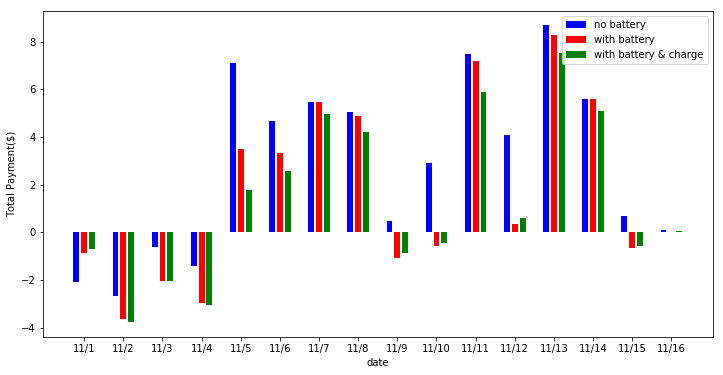

### Without Battery ### 
cost: 94.09, revenue: 48.62, total: 45.47
Sell to grid: 121.99
total consumption(kw): 82.30, low: 16.20%, mid: 44.19%, high: 39.61%

### With Battery ### 
cost: 43.97, revenue: 17.26, total: 26.71
Sell to grid: 38.61
total consumption(kw): 36.39, low: 22.56%, mid: 36.63%, high: 40.81%

### With Battery & charge ### 
cost: 45.56, revenue: 24.35, total: 21.22
total consumption(kw): 47.77, low: 24.28%, mid: 55.09%, high: 20.63%
Sell to grid: 57.52



In [168]:
import matplotlib.pyplot as plt

X = np.arange(16)
plt.figure(figsize=(12, 6))
plt.bar(X-0.2, home_no_battery.total_bill(), color='b', width=0.15, label='no battery')
plt.bar(X, home_with_battery.total_bill(), color='r', width=0.15, label='with battery')
plt.bar(X+0.2, home_with_battery_charge.total_bill(), color='g', width=0.15, label='with battery & charge')
plt.xticks(X, ['11/{:d}'.format(i) for i in range(1, 17)])
plt.xlabel('date')
plt.ylabel('Total Payment($)')
plt.legend(loc='upper right')
plt.show()
print('### Without Battery ### \ncost: {:.2f}, revenue: {:.2f}, total: {:.2f}'.format(sum(home_no_battery.result['cost']), sum(home_no_battery.result['revenue']), sum(home_no_battery.result['cost'])-sum(home_no_battery.result['revenue'])))
print('Sell to grid: {:.2f}'.format(sum(home_no_battery.result['sell_to_grid'])))
home_no_battery.show_usage()
print('')
print('### With Battery ### \ncost: {:.2f}, revenue: {:.2f}, total: {:.2f}'.format(sum(home_with_battery.result['cost']), sum(home_with_battery.result['revenue']), sum(home_with_battery.result['cost'])-sum(home_with_battery.result['revenue'])))
print('Sell to grid: {:.2f}'.format(sum(home_with_battery.result['sell_to_grid'])))
home_with_battery.show_usage()
print('')
print('### With Battery & charge ### \ncost: {:.2f}, revenue: {:.2f}, total: {:.2f}'.format(sum(home_with_battery_charge.result['cost']), sum(home_with_battery_charge.result['revenue']), sum(home_with_battery_charge.result['cost'])-sum(home_with_battery_charge.result['revenue'])))
home_with_battery_charge.show_usage()
print('Sell to grid: {:.2f}'.format(sum(home_with_battery_charge.result['sell_to_grid'])))
print('')


In [177]:
demand_t = pd.read_csv('../Data/electricity/test_electricity.csv')

demands = []
for i, row in demand_t.iterrows():
    if row['grid'] < 0:
        demands.append(row['solar'] - ((-1)*row['grid']))
    else:
        demands.append(row['grid']+row['solar'])
demand_t['demand'] = demands

Finish preprocessing
weather record size:  (365, 10)
solar record size:  (365, 1)
Train X size:  (292, 10)
Train y size:  (292, 1)
Test X size:  (73, 10)
Test y size:  (73, 1)
Score:  0.6755086052525108
Finish training



/Users/Rycemond/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


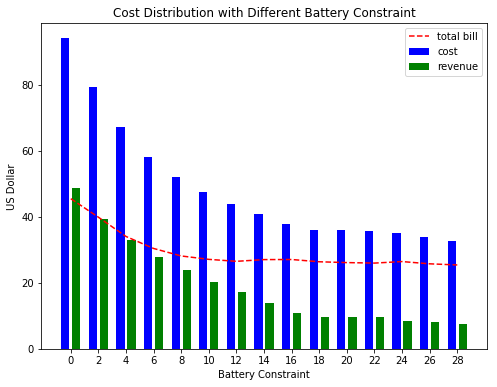

[45.46631250000006,
 39.86218750000005,
 34.02934374999999,
 30.3895625,
 28.122093749999994,
 27.09224999999995,
 26.49584374999995,
 27.022531249999965,
 27.047312499999965,
 26.361999999999995,
 26.11199999999998,
 25.962406249999972,
 26.423531249999968,
 25.74081249999997,
 25.397468749999977]

In [178]:
import matplotlib.pyplot as plt
import numpy as np

test = demand_t.iloc[:]
total_records = []
cost_records = []
rev_records = []
reduce_records = []

withcharge = []
nocharge = []

bc_test_size = 30
home = Home()
for bc in range(0, bc_test_size, 2):
    home.set_battery(bc)
    home.simuate(test, autocharge=False)
    cost_records.append(sum(home.result['cost']))
    rev_records.append(sum(home.result['revenue']))     
    total_records.append(sum(home.result['cost'])-sum(home.result['revenue']))
    nocharge.append(sum(home.result['cost'])-sum(home.result['revenue']))
    reduce_records.append(sum(home.result['reduce']))
    
    home.simuate(test, autocharge=True)
    withcharge.append(sum(home.result['cost'])-sum(home.result['revenue']))
    print(bc, end='\r')

plt.figure(figsize=(8, 6))

plt.plot([str(i) for i in range(0, bc_test_size, 2)], total_records, label='total bill', linestyle="--", color='r')

X = np.arange(bc_test_size/2)
plt.xlabel('Battery Constraint')
plt.ylabel('US Dollar')
plt.bar(X-0.2, cost_records, color='b', label='cost', width=0.3)
plt.bar(X+0.2, rev_records, color='g', label='revenue', width=0.3)
#plt.bar(X+0.2, reduce_records, color='r', label='reduce', width=0.15)
plt.legend(loc='upper right')
plt.title('Cost Distribution with Different Battery Constraint')
plt.show()
total_records

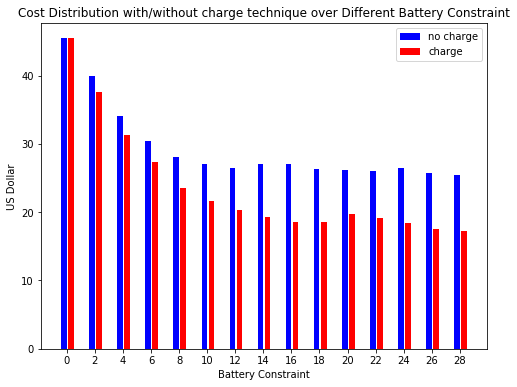

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize=(8, 6))
X = np.arange(bc_test_size/2)
plt.xlabel('Battery Constraint')
plt.ylabel('US Dollar')
plt.bar(X-0.1, nocharge, color='b', label='no charge', width=0.2)
plt.bar(X+0.15, withcharge, color='r', label='charge', width=0.2)
plt.xticks(X, [str(x) for x in range(0, bc_test_size, 2)])
plt.legend(loc='upper right')
plt.title('Cost Distribution with/without charge technique over Different Battery Constraint')
plt.show()
plt.savefig('battery_cost_charge.png')

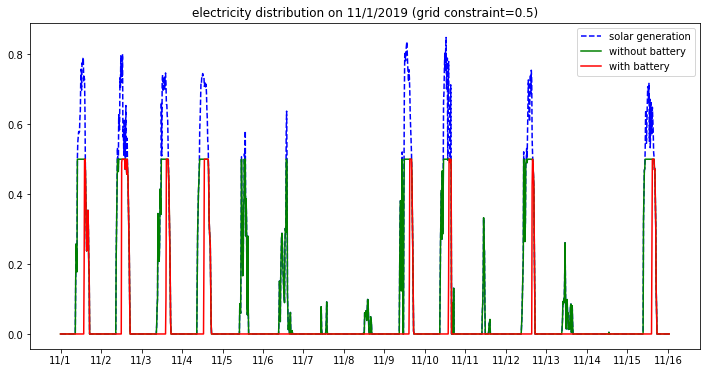

In [136]:

plt.figure(figsize=(12, 6))
plt.plot(home_no_battery2.result[:]['sell_to_grid'], '--' ,color='b', label='solar generation')
plt.plot(home_no_battery.result[:]['sell_to_grid'], color='g', label='without battery')
plt.plot(home_with_battery.result[:]['sell_to_grid'], color='r', label='with battery')
plt.legend(loc='upper right')
x = np.array([(i)*96 for i in range(16)])
my_xticks = ['11/{:d}'.format(i+1) for i in range(16)]
plt.xticks(x, my_xticks)
plt.title('electricity distribution on 11/1/2019 (grid constraint=0.5)')
plt.show()


In [121]:
test3 = demand_test.loc[:]
home_no_battery2 = Home(battery_const=0)
home_no_battery2.simuate(test3, autocharge=False)

Finish preprocessing
weather record size:  (365, 10)
solar record size:  (365, 1)
Train X size:  (292, 10)
Train y size:  (292, 1)
Test X size:  (73, 10)
Test y size:  (73, 1)
Score:  0.4714476412488228
Finish training



/Users/Rycemond/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


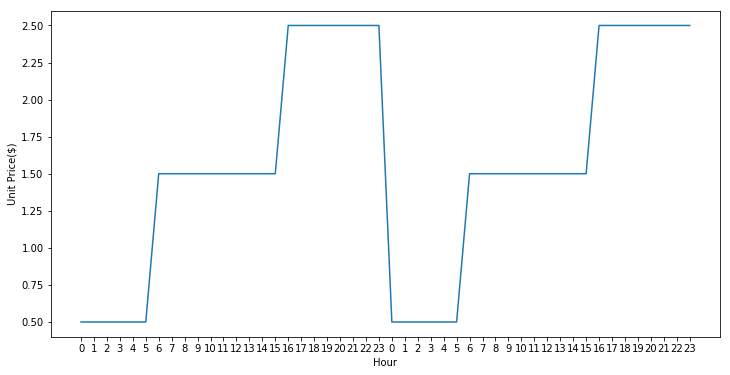

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(Home.UNIT_PRICE*2)
X = np.arange(24*2)
plt.xticks(X, [i for i in range(24)]*2)
plt.xlabel('Hour')
plt.ylabel('Unit Price($)')
plt.show()

Finish preprocessing
weather record size:  (365, 10)
solar record size:  (365, 1)
Train X size:  (292, 10)
Train y size:  (292, 1)
Test X size:  (73, 10)
Test y size:  (73, 1)
Score:  0.7114690471118837
Finish training



/Users/Rycemond/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


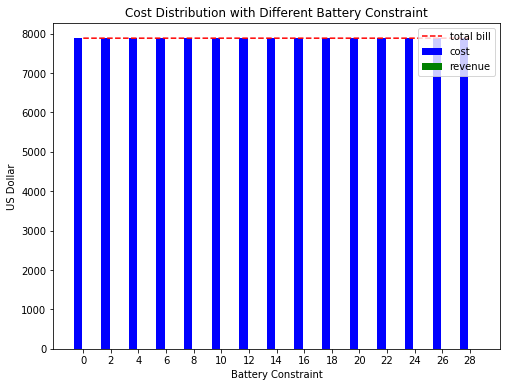

[7883.737874999988,
 7883.737874999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988,
 7883.725374999988]

In [164]:
import matplotlib.pyplot as plt
import numpy as np

test = demand_t.iloc[:]
total_records = []
cost_records = []
rev_records = []
reduce_records = []

withcharge = []
nocharge = []

bc_test_size = 30
home = Home()

for bc in range(0, bc_test_size, 2):
    home.set_battery(bc)
    home.simuate(test, autocharge=False)
    cost_records.append(sum(home.result['cost']))
    rev_records.append(sum(home.result['revenue']))     
    total_records.append(sum(home.result['cost'])-sum(home.result['revenue']))
    nocharge.append(sum(home.result['cost'])-sum(home.result['revenue']))
    reduce_records.append(sum(home.result['reduce']))
    
    home.simuate(test, autocharge=True)
    withcharge.append(sum(home.result['cost'])-sum(home.result['revenue']))
    print(bc, end='\r')

plt.figure(figsize=(8, 6))

plt.plot([str(i) for i in range(0, bc_test_size, 2)], total_records, label='total bill', linestyle="--", color='r')

X = np.arange(bc_test_size/2)
plt.xlabel('Battery Constraint')
plt.ylabel('US Dollar')
plt.bar(X-0.2, cost_records, color='b', label='cost', width=0.3)
plt.bar(X+0.2, rev_records, color='g', label='revenue', width=0.3)
#plt.bar(X+0.2, reduce_records, color='r', label='reduce', width=0.15)
plt.legend(loc='upper right')
plt.title('Cost Distribution with Different Battery Constraint')
plt.show()
total_records